### Practical Session on Recurrent Neural Networks

#### This session demonstrates the application of RNNs using sentiment classification on TripAdvisor reviews. Long Short Term Memory (LSTM) network is used to model sequential text data found in reviews and to develop a Binary Classification model which learns to predict review sentiment as positive or negative.

In [ ]:
# ! pip install --user -r requirements.txt
from IPython import get_ipython
import warnings
warnings.filterwarnings("ignore")
ipython = get_ipython()
ipython.magic("sx wget https://www.dropbox.com/s/80yl6pxjx7usk4p/ISB_PyTorch_Tutorial.zip") 
!unzip -q ISB_PyTorch_Tutorial.zip
!mv ISB_PyTorch_Tutorial/* .

In [ ]:
import torch
import random
import numpy as np

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.use_deterministic_algorithms(True)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import re
import warnings

warnings.filterwarnings("ignore")

import pandas as pd

from gensim.models import KeyedVectors

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
"""Params for training & evaluation
dataFileName: TAB separated file having reviews and ratings
embeddingDim: Size of Word embeddings. We'll use pretrained FastText Word Embeddings - https://github.com/facebookresearch/MUSE
"""
dataFileName = "TripAdvisor_Hotel_Restaurant_Review_Samples.txt"
embeddingDim = 300                                               

#### Exploratory Data Analysis

In [ ]:
"""
Read the data into a pandas DataFrame. Only the second and third columns are required.
The second column is review text and third one is review rating on a scale of 0-10.
"""
df = pd.read_csv(dataFileName, sep="\t", header=None, usecols=[0,1], names=["Rating", "Review"], encoding="utf8")
print("No. of reviews:", df.shape[0])
df.head(10)

No. of reviews: 100000


,Rating,Review
0,10.0,A dream cottage in a dream village. A very per...
1,10.0,Always stay here when in Brighton and wouldn't...
2,10.0,A warm welcome awaits at this secluded B+B. Br...
3,10.0,Ann and David are perfect hosts and a stay in ...
4,10.0,A very comfortable B&B located a short walk ou...
5,10.0,"Comfortable, cosy, clean accommodation. Warm w..."
6,8.0,I stayed here as part of a large group of girl...
7,10.0,I have just returned from a Stag Weekend with ...
8,10.0,4th time we have stayed here. Ther were 9 of u...
9,10.0,12 of us just stayed here on my hen weekend 21...


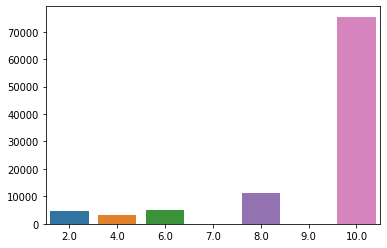

In [ ]:
"""
Let's take a quick look at the distribution of different ratings
"""
rating_frequency_count = df.Rating.value_counts()
sns.barplot(x=rating_frequency_count.index, y=rating_frequency_count.values)

In [ ]:
"""
Add "Sentiment" column to the DataFrame based on the rule: IF Rating <= 5 THEN Negative ELSE Positive.
Later, we will use the Review and Sentiment columns to train a Binary Classifier
"""
df["Sentiment"] = df["Rating"].map(lambda x: "Negative" if x <= 5 else "Positive")
df.head(10)

,Rating,Review,Sentiment
0,10.0,A dream cottage in a dream village. A very per...,Positive
1,10.0,Always stay here when in Brighton and wouldn't...,Positive
2,10.0,A warm welcome awaits at this secluded B+B. Br...,Positive
3,10.0,Ann and David are perfect hosts and a stay in ...,Positive
4,10.0,A very comfortable B&B located a short walk ou...,Positive
5,10.0,"Comfortable, cosy, clean accommodation. Warm w...",Positive
6,8.0,I stayed here as part of a large group of girl...,Positive
7,10.0,I have just returned from a Stag Weekend with ...,Positive
8,10.0,4th time we have stayed here. Ther were 9 of u...,Positive
9,10.0,12 of us just stayed here on my hen weekend 21...,Positive


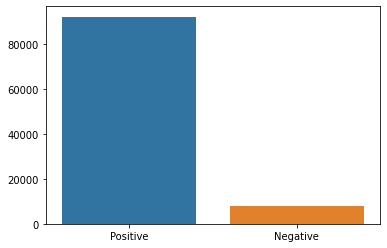

In [ ]:
"""
Let's take a quick look at the distribution of sentiments
"""
rating_frequency_count = df.Sentiment.value_counts()
sns.barplot(x=rating_frequency_count.index, y=rating_frequency_count.values)

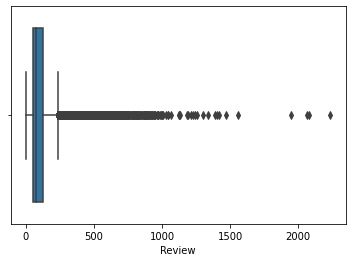

In [ ]:
"""
Now let's find out a value for maxlen. For that, we first look at the distribution of review lengths in terms of 
number of words. A box plot is used to visualize this distribution.
"""

re_wordMatcher = re.compile(r'[a-z0-9]+') #Declare regex to extract words
numWords = df["Review"].map(lambda x: len(re_wordMatcher.findall(x.lower())))
g = sns.boxplot(numWords)

In [ ]:
"""
The above plot shows that there are few very long reviews (black dots on the right) but most of the reviews are
comparatively shorter than around 250 words. Specifically, let's find the 90th quantile of the review length. 
"""

reviewLen90 = np.quantile(numWords, 0.90)
print("90th quantile of review length:", reviewLen90)

90th quantile of review length: 191.0


In [ ]:
"""
Thus, 90% of reviews are of 191 words or shorter. We'll set maxlen close to this.
"""
maxlen = 190

In [ ]:
"""
Lets's create training and test datasets by keeping ratio between the positive and negative labels same.
We use sklearn.model_selection.StratifiedKFold setting number of folds (n_splits) = 5, which splits the data into
80% train and 20% test and for 5 folds. But we keep only the first fold for this demo.
"""
labels = np.array(df["Sentiment"].map(lambda x: 1. if x == "Negative" else 0.))
skf = StratifiedKFold(n_splits=5)
for trn_idx, tst_idx in skf.split(labels.reshape((-1, 1)), labels):
    break

train_df, test_df = df.iloc[trn_idx], df.iloc[tst_idx]

print("Shape of train and test dataframes:", train_df.shape, test_df.shape)

Shape of train and test dataframes: (80000, 3) (20000, 3)


#### Data Processing: Review & Sentiment to Numeric Features & Labels for Model Training & Evaluation

In [ ]:
#Read FastText En model. If the file wiki.multi.en.vec' does not exist, download it from 
# https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.en.vec
!pip install wget
import wget
word2VecFile = os.path.join(os.curdir, 'wiki.multi.en.vec')

if os.path.exists(word2VecFile):
    print('Word2Vec file has been found and is being loaded...')
else:    
    print('Word2Vec file does not exist and needs to be downloaded')
    url = 'https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.en.vec'
    wget.download(url)
    print('Downloading from', url)
en_model = KeyedVectors.load_word2vec_format('wiki.multi.en.vec')

Word2Vec file has been found and is being loaded...


In [ ]:
"""
Now let us create a numpy array containing the word vectors. Later this numpy array will be used for initilaizing 
the embedding layer in the model.
"""

vocab = list(en_model.vocab.keys())
print("Vocab size in pretrained model:", len(vocab))

# check if the word 'and' is present in the pretrained model
assert "and" in en_model

# check the dimension of the word vectors
assert embeddingDim == len(en_model["and"])

# initialize a numpy matrix which will store the word vectors
# first row is for the padding token
pretrained_weights = np.zeros((1+len(vocab), embeddingDim))

# tqdm just adds a progress bar
for i, token in enumerate(vocab):
    pretrained_weights[i, :] = en_model[token]

# map tokens in the vocab to ids
vocab = dict(zip(vocab, range(1, len(vocab)+1)))

Vocab size in pretrained model: 200000


In [ ]:
def reviewText2Features(reviewText):
    """
    Function which takes review text (basically a string!) as input and returns a features matrix X of shape
    (maxlen, embeddingDim). This is done by splitting the review into words and then representing each word by it's
    word vector obtained from the Word2Vec model. Sentences having more than maxlen words are truncated while shorter
    ones are zero-padded by pre-adding all zero vectors.
    """
    X = []
    
    reviewWords = re_wordMatcher.findall(reviewText.lower())
    
    """
    Tokenize the review using the word-matching regex and get its word vector from the pretrained Word2Vec model.
    Words not found in the Word2Vec model are ignored
    """
    for i, word in enumerate(reviewWords):
        if word not in en_model:
            continue
        if i >= maxlen:
            break
        # X.append(en_model[word])
        X.append(vocab[word])
    
    """
    Add zero padding in the begining of the sequence if the number of words is less than maxlen.
    """
    if len(X) < maxlen:
        # zero_padding = [[0.]*embeddingDim]*(maxlen - len(X))
        zero_padding = [0.]*(maxlen - len(X))
        X = zero_padding + X
    
    return X # np.array(X)
        
def row2Features(row):
    """
    Function which takes a datafram row as input and produces features and labels.
    
    Input: row | Type: pandas.core.series.Series
    
    Output: X, y | Type: X - np.ndarray of shape (maxlen, embeddingDim) & y - int where Positive = 0 & Negative = 1
    """    
    
    X = reviewText2Features(row["Review"])
    y = 1. if row["Sentiment"] == "Negative" else 0.
        
    return X, y

In [ ]:
"""
Now apply the above function on a sample row
"""
sampleRow = df.iloc[0]
reviewWords = re_wordMatcher.findall(sampleRow["Review"].lower())
print("Review:", sampleRow["Review"])
print("Rating:", sampleRow["Rating"])
print("Sentiment:", sampleRow["Sentiment"])
print("Review words:", reviewWords)

Review: A dream cottage in a dream village. A very personal service so hard to find these days and by far the most idealistic B & B i have stayed in. Would highly recommend and looking forward to staying again when next in the area. Cornwall.
Rating: 10.0
Sentiment: Positive
Review words: ['a', 'dream', 'cottage', 'in', 'a', 'dream', 'village', 'a', 'very', 'personal', 'service', 'so', 'hard', 'to', 'find', 'these', 'days', 'and', 'by', 'far', 'the', 'most', 'idealistic', 'b', 'b', 'i', 'have', 'stayed', 'in', 'would', 'highly', 'recommend', 'and', 'looking', 'forward', 'to', 'staying', 'again', 'when', 'next', 'in', 'the', 'area', 'cornwall']


In [ ]:
"""
Give the sample row to the function row2Features
"""
X, y = row2Features(sampleRow)
print("Dimension of X:", len(X))
print("Label y:", y)

Dimension of X: 190
Label y: 0.0


In [ ]:
def shuffleArray(X, y):
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    X = X[idx, :]
    y = y[idx]
    return X, y

def generateModelReadyData(data, batchSize = 128, shuffle=False):
    """
    Generator function which generates features and labels in batches
    
    Input:
    data - DataFrame where each row has review and sentiment
    batchSize - No. of rows for which features will be created and returned in a batch.
    Note: This is useful for running mini-batch Gradient Descent optimization when the dataset is large.
    
    Output:
    X - 3D np.ndarray of shape (batchSize, maxlen, embeddingDim)
    y - 1D np. array of shape (batchSize,)        
    """
    
    while(True):
        X = []
        y = []
        for _, row in data.iterrows():
            """Generate features and label for this row"""
            X_, y_ = row2Features(row)

            """Keep accumulating the row-wise features"""
            X.append(X_)
            y.append(y_)   

            """If number of rows processed is greater than batchSize yield the batch and trim down X & y
            Note: This way we avoid running into memory issues by not bloating X and y bigger and bigger
            """
            if len(X) > batchSize:
                temp_X, temp_y = np.array(X[:batchSize]), np.array(y[:batchSize])
                if shuffle:
                    temp_X, temp_y = shuffleArray(temp_X, temp_y)
                
                X, y = X[batchSize:], y[batchSize:]                    
                yield temp_X, temp_y

        """Yield the remaining few rows when number of rows in data isn't a mutiple of batchSize"""
        if len(X) > 0:
            temp_X, temp_y = np.array(X), np.array(y)
            if shuffle:
                temp_X, temp_y = shuffleArray(temp_X, temp_y)
            
            yield temp_X, temp_y

In [ ]:
"""Let's test the generator function for few batches"""
numBatches = 0
for i, (X, y) in enumerate(generateModelReadyData(df, batchSize=128, shuffle=True)):
    if numBatches >= 3:
        break
    
    else:
        print("Batch:", i)
        assert X.shape == (128, maxlen)
        assert y.shape == (128,)
        print("Shape of X & y matches expected values")
    numBatches += 1

Batch: 0
Shape of X & y matches expected values
Batch: 1
Shape of X & y matches expected values
Batch: 2
Shape of X & y matches expected values


#### Model Training in Pytorch

In [ ]:
"""
Now we will train and evaluate the model. We'll use Pytorch.
"""

"\nNow we will train and evaluate the model. We'll use Pytorch.\n"

In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    print("cuda available")
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
"""
Set random number seed using torch.manual_seed to make sure the same seed is used
by the Pytorch backend and hence ensure repeatable results
"""
torch.manual_seed(0)

In [ ]:
"""
Next, we'll declare the layers of the neural network
"""

"\nNext, we'll declare the layers of the neural network\n"

In [ ]:
class SentimentNet(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, pretrained_weights):
        super(SentimentNet, self).__init__()
        
        self.embedding=nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_weights))
        
        """
        Adding a dropout layer to force some of the feature values to zero.
        Note: Dropout is a regularization technique which sets the activation of few randomly chosen neurons of
        a hidden layer to zero. It can also be applied to the input layer where some of the input features are set to zero.
        For more details refer http://jmlr.org/papers/v15/srivastava14a.html
        """
        self.sentInputDropout = nn.Dropout(0.2)
        
        """
        Now let's stack a couple of bidirectional RNNs to process the input sequence and extract features
        """
        self.biLSTM1 = nn.LSTM(embedding_dim, hidden_dim[0], bidirectional=True, batch_first=True)
        self.biLSTMDropOut = nn.Dropout(0.2)
        self.biLSTM2 = nn.LSTM(2*hidden_dim[0], hidden_dim[1], bidirectional=True, batch_first=True)
        
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.Linear(2*hidden_dim[1], 64)
        self.relu1 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        
        self.outputLayer = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        
        self.hidden_dim = hidden_dim
        
    def forward(self, x):
        
        batch_len = x.shape[0]
        out = self.embedding(x)
        out = self.sentInputDropout(out)
        out, hidden = self.biLSTM1(out)
        out = self.biLSTMDropOut(out)
        out, hidden = self.biLSTM2(out)
        
        out = self.dropout1(out)
        out = self.dense1(out)
        out = self.relu1(out)
        out = self.dropout2(out)
        
        out = self.outputLayer(out)
        out = self.sigmoid(out)
        out = out.view(batch_len, -1)
        out = out[:,-1]
        return out    

In [ ]:
model = SentimentNet(embeddingDim, [256, 128], 1+len(vocab), pretrained_weights)
model.to(device)

SentimentNet(
  (embedding): Embedding(200001, 300)
  (sentInputDropout): Dropout(p=0.2, inplace=False)
  (biLSTM1): LSTM(300, 256, batch_first=True, bidirectional=True)
  (biLSTMDropOut): Dropout(p=0.2, inplace=False)
  (biLSTM2): LSTM(512, 128, batch_first=True, bidirectional=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dense1): Linear(in_features=256, out_features=64, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (outputLayer): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
lr=0.005
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
epochs = 1
counter = 0
print_every = 1000
clip = 5
valid_loss_min = np.Inf

model = model.float()
model.train()
for i in range(epochs):
    print("Epoch:", i+1)
    #h = model.init_hidden(128)
    print("Running a pass over the training data...")
    for j, (inputs, labels) in enumerate(generateModelReadyData(train_df, batchSize=128, shuffle=True)):
        if j >= np.ceil(train_df.shape[0]/128):
            break
        
    #for inputs, labels in train_loader:
        counter += 1
        #h = tuple([e.data for e in h])
        inputs, labels = torch.from_numpy(inputs), torch.from_numpy(labels)
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        #output, h = model(inputs, h)
        output = model(inputs.long())
        #print(output.shape)
        #print(output)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()        
        if (j+1) % 100 == 0:
            print("Batches completed:", j+1)
    
    print("Batches completed:", j+1)

    #val_h = model.init_hidden(batch_size)
    val_losses = []
    model.eval()
    print("Running a pass over the test data...")
    for k, (inp, lab) in enumerate(generateModelReadyData(test_df, batchSize=128, shuffle=False)):
        if k >= np.ceil(test_df.shape[0]/128):
            break
    #for inp, lab in val_loader:
        #val_h = tuple([each.data for each in val_h])
        inp, lab = torch.from_numpy(inp), torch.from_numpy(lab)
        inp, lab = inp.to(device), lab.to(device)
        out = model(inp.long())
        val_loss = criterion(out.squeeze(), lab.float())
        val_losses.append(val_loss.item())
        if (k+1) % 100 == 0:
            print("Batches completed:", k+1)
    
    print("Batches completed:", k+1)

    model.train()
    print("Epoch: {}/{}...".format(i+1, epochs),
          "Step: {}...".format(counter),
          "Loss: {:.6f}...".format(loss.item()),
          "Val Loss: {:.6f}".format(np.mean(val_losses)))
    if np.mean(val_losses) <= valid_loss_min:
        torch.save(model.state_dict(), './state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
        valid_loss_min = np.mean(val_losses)

Epoch: 1
Running a pass over the training data...


In [ ]:
"""
Earlier we have seen that the review sentiments are imbalanced with more number of Positive cases than Negative ones.
Imbalance datasets make it difficult for the model to learn patterns for the under-represented class.
We tackle this problem by introducing class weights during training which are used to assign higher weightage
to errors made in predicting the under-represented class.

Class weights are computed from inverse of frequency counts as follows.
"""
freqCounts = train_df["Sentiment"].value_counts()
weightOfPositive = round( (1./freqCounts["Positive"]) / (1./freqCounts["Positive"] + 1./freqCounts["Negative"]), 3)
weightOfNegative = round( (1./freqCounts["Negative"]) / (1./freqCounts["Positive"] + 1./freqCounts["Negative"]), 3)
print("Class weights:", weightOfPositive, weightOfNegative)

In [ ]:
"""
For making predictions, optionally you can use CPU instead of GPU. But for that we need to change the device so that Pytorch can 
run on CPU. Let us change the device here.
"""
# device = torch.device("cpu")

#### Model Evaluation

In [ ]:
!ls

In [ ]:
"""
At this point we can load a pretrained model which was trained for 5 epochs and make predictions using it.
Uncomment and run the below line to load the pretrained model
"""
model.load_state_dict(torch.load('./state_dict.pt'))
model.to(device)

In [ ]:
test_losses = []
num_correct = 0
pred_proba = []
actual = []

model.eval()
for j, (X_test, y_test) in enumerate(generateModelReadyData(test_df, batchSize=128)):
    if j >= np.ceil(test_df.shape[0]/128):
        break
    
    inputs_test, labels_test = torch.from_numpy(X_test), torch.from_numpy(y_test)
    inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
    output_test = model(inputs_test.long())
    test_loss = criterion(output_test.squeeze(), labels_test.float())
    test_losses.append(test_loss.item())
    pred = torch.round(output_test.squeeze())  # Rounds the output to 0/1
    correct_tensor = pred.eq(labels_test.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)
    pred_proba.extend(output_test.cpu().squeeze().detach().numpy())
    actual.extend(y_test)
    
    if (j+1) % 100 == 0:
        print("Batches completed:", j+1)

print("Batches completed:", j+1)

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_df)
print("Test accuracy: {:.3f}%".format(test_acc*100))

In [ ]:
"""
Evaluate using Area Under Reciever Operating Charecteristic curve
Reference on AUC-ROC: https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5
"""
print("Area under ROC:", roc_auc_score(actual, pred_proba))

In [ ]:
"""
Let's plot the ROC curve.
First, we will compute False Positive Rate (FPR) & True Postive Rate (TPR) for different values of threshold and
find the area under the curve.
Note: Positive here indicates class label = 1 which is Negative sentiment in our case
      Negative indicates class label = 0 which is Positive sentiment in our case
"""
fpr, tpr, thresholds = roc_curve(actual, pred_proba) 
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
"""
Let's convert predicted probabilites to predicted sentiments using a threshold=0.10
and compute the confusion matrix
"""

predicted = pd.Series(["Negative" if p>=0.10 else "Positive" for p in pred_proba], name="Predicted")
actual = pd.Series(test_df["Sentiment"], name="Actual")
confusion_matrix = pd.crosstab(actual, predicted)

In [ ]:
"""Plot the confusion matrix"""

ax= plt.subplot()
g = sns.heatmap(confusion_matrix.as_matrix(), annot=True, ax = ax, fmt="d", cmap="YlGnBu")
g.set_xlabel('Predicted')
g.set_ylabel('Actual')
g.set_title('Confusion Matrix')
g.xaxis.set_ticklabels(['Negative', 'Positive'])
g.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()

#### Sentiment Prediction for new reviews

In [ ]:
"""
Let us now see how to predict Sentiment of a review. For this we'll use the function
reviewText2Features which converts a review into a feature matrix X. However, X is 2D tensor while the model's network
expects a 3D tensor of dimensions (batch_size, maxlen, embeddingDim). Hence, for a single review we reshape the output
of reviewText2Features to dimensions (1, maxlen, embeddingDim). This 3D matrix is given to the model which outputs predicted
probability. This in turn is converted to Sentiment applying the above threshold.

The below function wraps in all these logic.
"""

def predictSentiment(reviewText):
    X = reviewText2Features(reviewText)
    X = np.array(X).reshape((1, -1))
    X = torch.from_numpy(X)
    X = X.to(device)
    model.eval()
    pred_proba = model(X.long())
    pred_proba = pred_proba.cpu().squeeze().detach().numpy()
    if pred_proba >= 0.10:
        return "Negative", pred_proba
    else:
        return "Positive", pred_proba

In [ ]:
"""
Now test the above function with few positive and negative reviews from test_df
"""

pos_reviews = list(test_df["Review"].loc[test_df["Sentiment"] == "Positive"].iloc[:5])
neg_reviews = list(test_df["Review"].loc[test_df["Sentiment"] == "Negative"].iloc[:5])

for reviewText, actualSentiment in  zip(pos_reviews + neg_reviews, ["Positive"]*5+["Negative"]*5):
    sentiment, probability = predictSentiment(reviewText)
    """
    Since, the model always predicts probability of being Negative, we compute (1-probability) as 
    probability when predicted sentiment is Positive
    """
    if sentiment == "Positive":
        probability = 1 - probability
    
    probability = np.round(probability, 4)
    print("Review: ", reviewText)
    print("Actual Sentiment:", actualSentiment)
    print("Predicted Sentiment: ", sentiment)
    print("x---------------------------------------------------------------------------------------------------x")